In [1]:
import sys
sys.path.append( '../utilities' )
from data_engine import DataEngine
from backtesting import Backtesting
import pandas as pd
import ta
import ccxt
import pandas_ta as pda

In [2]:
# pairList = pairJson['hitbtc2018']
pair = 'SOL/USDT'
timeframe = '1h'
startDate = '2017-01-01T00:00:00'

dataEngine = DataEngine(session=ccxt.binance(), path_to_data='./database/')

df = dataEngine.get_historical_from_db(pair, timeframe, startDate)

Successfully load 13295 candles for SOLUSDT


In [3]:
# -- Indicator variable --
trixLength = 9
trixSignal = 21
stochWindow = 14

# -- Drop all columns we do not need --
df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)

# -- Indicators, you can edit every value --
df['TRIX'] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(close=df['close'], window=trixLength), window=trixLength), window=trixLength)
df['TRIX_PCT'] = df["TRIX"].pct_change()*100
df['TRIX_SIGNAL'] = ta.trend.sma_indicator(df['TRIX_PCT'], trixSignal)
df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']
df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=14, smooth1=3, smooth2=3)

df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=stochWindow)

print("Indicators loaded 100%")
df

Indicators loaded 100%


,open,high,low,close,volume,TRIX,TRIX_PCT,TRIX_SIGNAL,TRIX_HISTO,STOCH_RSI
timestamp,,,,,,,,,,
2020-08-11 06:00:00,2.8500,3.4700,2.8500,2.9515,20032.26,NaN,NaN,NaN,NaN,NaN
2020-08-11 07:00:00,2.9515,3.1355,2.8800,2.9224,42069.37,NaN,NaN,NaN,NaN,NaN
2020-08-11 08:00:00,2.9626,3.0000,2.9144,2.9600,24280.76,NaN,NaN,NaN,NaN,NaN
2020-08-11 09:00:00,2.9600,2.9736,2.8500,2.8543,26371.23,NaN,NaN,NaN,NaN,NaN
2020-08-11 10:00:00,2.8566,2.9329,2.8433,2.8976,26685.94,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-02-16 18:00:00,99.0900,100.1900,98.6800,100.1200,57686.93,102.051245,-0.183929,0.040503,-0.224432,0.320414
2022-02-16 19:00:00,100.0900,103.7000,99.2800,103.3600,260015.11,101.885509,-0.162404,0.027430,-0.189834,0.901957
2022-02-16 20:00:00,103.2600,103.5500,102.3400,102.6300,86825.30,101.754390,-0.128693,0.015355,-0.144048,0.761366


In [4]:
# -- Intern parameter --
dfTest = df['2017-01-01':]
#ndfTest = df[:]
startingBalance = 1000
makerFee = 0.0002
takerFee = 0.0007

# -- Rules --
StopLossActivation = False
takeProfitActivation = False
timeLimitActivation = False
showLog = False
waitNextSignal = False

# -- Hyper parameters --
stochOverBought = 0.85
stochOverSold = 0.25
SlPct = 0.02
TpPct = 0.02
timeLimit = 17


# -- Trade Functions --
# -- Condition to BUY market --

def buyCondition(row, previousRow):
    if (
        row['TRIX_HISTO'] >= 0
        and row['STOCH_RSI'] < stochOverBought
    ):
        return True
    else:
        return False

# -- Condition to SELL market --


def sellCondition(row, previousRow):
    if (
        row['TRIX_HISTO'] < 0
        and row['STOCH_RSI'] > stochOverSold
    ):
        return True
    else:
        return False


# -- Value initialisation --
usd = startingBalance
wallet = startingBalance
coin = 0
lastAth = 0
previousRow = dfTest.iloc[0]
stopLoss = 0
takeProfit = 500000
buyReady = True
sellReady = True
currentTimeOpen = 0
timeSince = 0

# -- Definition of dfTrades, that will be the dataset to do your trades analyses --
dfTrades = None
dfTrades = pd.DataFrame(columns=['date', 'position', 'reason',
                                 'price', 'frais', 'fiat', 'coins', 'wallet', 'timeSince'])

# -- Iteration on all your price dataset (df) --
for index, row in dfTest.iterrows():
    timeSince += 1
    if currentTimeOpen > 0:
        currentTimeOpen += 1
    # -- Buy market order --
    if buyCondition(row, previousRow) and usd > 0 and buyReady == True:
        # -- You can define here at what price you buy --
        buyPrice = row['close']

        # -- Define the price of you SL and TP or comment it if you don't want a SL or TP --
        if StopLossActivation:
            stopLoss = buyPrice - SlPct * buyPrice
        if takeProfitActivation:
            takeProfit = buyPrice + TpPct * buyPrice
        if timeLimitActivation:
            currentTimeOpen = 1

        fee = takerFee * usd
        usd = usd - fee
        coin = usd / buyPrice
        usd = 0
        wallet = coin * row['close']

        if showLog:
            print("Buy COIN at", buyPrice, '$ the', index)

        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Buy",
            'reason': 'Buy Market Order',
            'price': buyPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0

    # -- Take Profit --
    elif row['high'] > takeProfit and coin > 0:
        sellPrice = takeProfit
        usd = coin * sellPrice
        fee = makerFee * usd
        usd = usd - fee
        coin = 0
        wallet = usd

        if waitNextSignal:
            buyReady = False

        # -- You can uncomment the line below if you want to see logs --
        if showLog:
            print("Sell COIN at Take Profit", sellPrice, '$ the', index)

        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Sell",
            'reason': 'Sell Take Profit',
            'price': sellPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0
    # -- Stop Loss --
    elif row['low'] < stopLoss and coin > 0:
        sellPrice = stopLoss
        usd = coin * sellPrice
        fee = makerFee * usd
        usd = usd - fee
        coin = 0
        wallet = usd

        currentTimeOpen = 0

        if waitNextSignal:
            buyReady = False

        # -- You can uncomment the line below if you want to see logs --
        if showLog:
            print("Sell COIN at Stop Loss", sellPrice, '$ the', index)
        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Sell",
            'reason': 'Sell Stop Loss',
            'price': sellPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0

    # -- Sell Market Order --
    elif sellCondition(row, previousRow):
        buyReady = True
        if coin > 0:
            # -- You can define here at what price you buy --
            sellPrice = row['close']
            usd = coin * sellPrice
            fee = takerFee * usd
            usd = usd - fee
            coin = 0
            # buyReady = True
            wallet = usd

            # -- You can uncomment the line below if you want to see logs --
            if showLog:
                print("Sell COIN at", sellPrice, '$ the', index)

            # -- Add the trade to DfTrades to analyse it later --
            myrow = {
                'date': index,
                'position': "Sell",
                'reason': 'Sell Market Order',
                'price': sellPrice,
                'frais': fee,
                'fiat': usd,
                'coins': coin,
                'wallet': wallet,
                'timeSince': timeSince
            }
            dfTrades = dfTrades.append(myrow, ignore_index=True)
            timeSince = 0

    elif currentTimeOpen > timeLimit and coin > 0:
        sellPrice = row['close']
        usd = coin * sellPrice
        fee = takerFee * usd
        usd = usd - fee
        coin = 0
        if waitNextSignal:
            buyReady = False
        wallet = usd

        # -- You can uncomment the line below if you want to see logs --
        if showLog:
            print("Sell COIN at", sellPrice, '$ the', index)

        # -- Add the trade to DfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Sell",
            'reason': 'Sell Time Market Order',
            'price': sellPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0
    previousRow = row

print("Final wallet", wallet)
print(dfTrades)


Final wallet 30780.299624116735
                   date position             reason     price      frais  \
0   2020-08-15 10:00:00      Buy   Buy Market Order    3.4852   0.700000   
1   2020-08-16 00:00:00     Sell  Sell Market Order    3.2414   0.650577   
2   2020-08-16 08:00:00      Buy   Buy Market Order    3.3530   0.650122   
3   2020-08-17 08:00:00     Sell  Sell Market Order    3.2862   0.636724   
4   2020-08-18 11:00:00      Buy   Buy Market Order    3.0672   0.636278   
..                  ...      ...                ...       ...        ...   
695 2022-02-12 01:00:00     Sell  Sell Market Order   97.7700  20.105045   
696 2022-02-12 13:00:00      Buy   Buy Market Order   95.0400  20.090971   
697 2022-02-13 20:00:00     Sell  Sell Market Order   93.5900  19.770599   
698 2022-02-14 08:00:00      Buy   Buy Market Order   93.7000  19.756760   
699 2022-02-15 18:00:00     Sell  Sell Market Order  102.3300  21.561303   

             fiat       coins        wallet timeSince  

In [5]:
BTobject = Backtesting()
newDf = BTobject.simple_spot_backtest_analys(dfTrades=dfTrades, dfTest=dfTest, pairSymbol=pair, timeframe=timeframe)

Pair Symbol : SOL/USDT | Timeframe : 1h
Period : [2020-08-11 06:00:00] -> [2022-02-16 22:00:00]
Starting balance : 999.3 $

----- General Informations -----
Final balance : 30780.3 $
Performance vs US Dollar : 2980.19 %
Buy and Hold Performence : 3366.71 %
Performance vs Buy and Hold : -11.15 %
Best trade : +57.06 %, the 2021-08-17 01:00:00
Worst trade : -22.6 %, the 2020-09-05 13:00:00
Worst drawDown : - 47.48 %
Total fees :  4724.98 $

----- Trades Informations -----
Total trades on period : 350
Number of positive trades : 162
Number of negative trades :  188
Trades win rate ratio : 46.29 %
Average trades performance : 1.34 %
Average positive trades : 6.93 %
Average negative trades : -3.47 %

----- Time Informations -----
Average time duration for a trade : 19.94 periods
Maximum time duration for a trade : 56 periods
Minimum time duration for a trade : 1 periods
Average time duration between two trades : 17.97 periods
Maximum time duration between two trades : 101 periods
Minimum tim

----- 2020 Performances: 26.0% -----


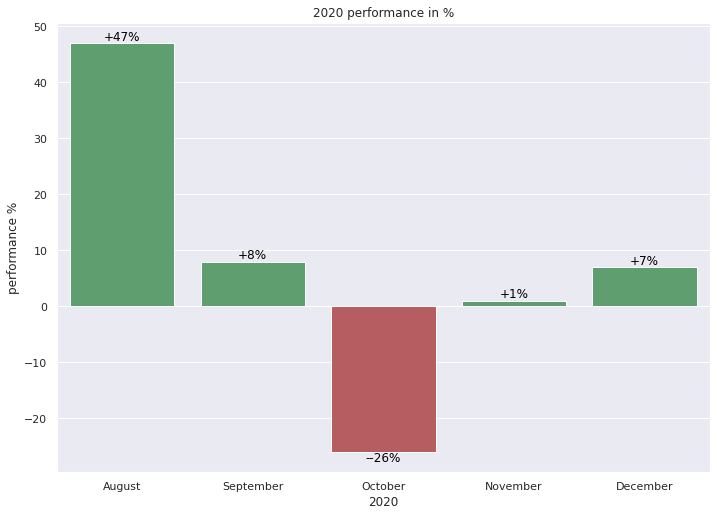

----- 2021 Performances: 1874.02% -----


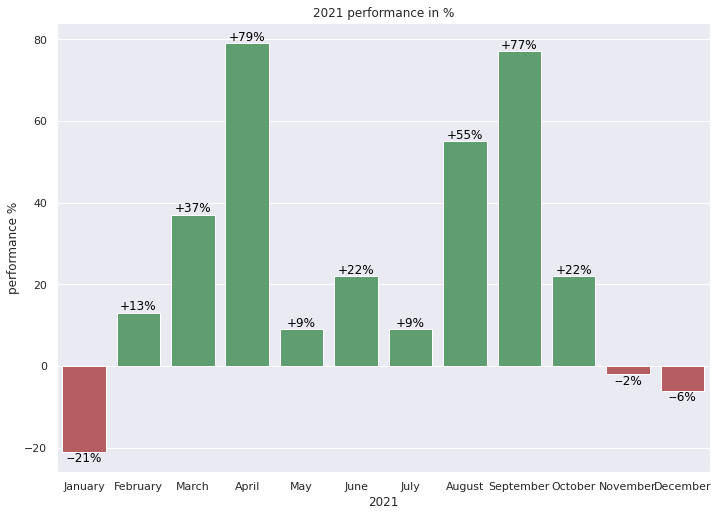

----- 2022 Performances: 4.57% -----


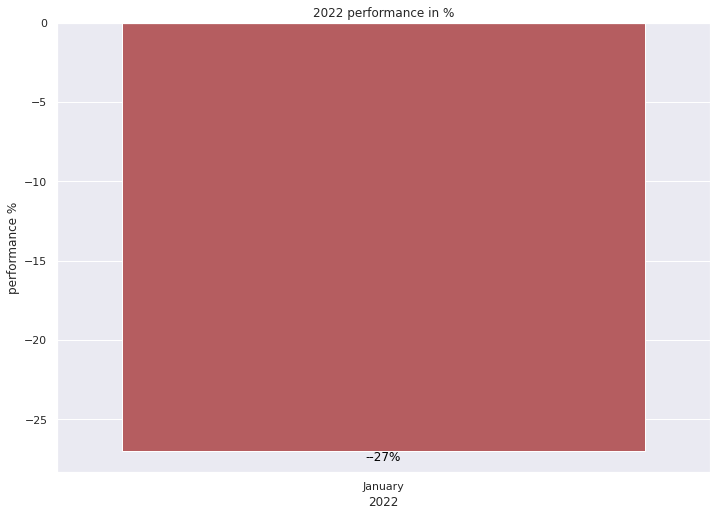

In [6]:
BTobject.plot_bar_by_month(dfTrades=dfTrades)


----- Plot -----


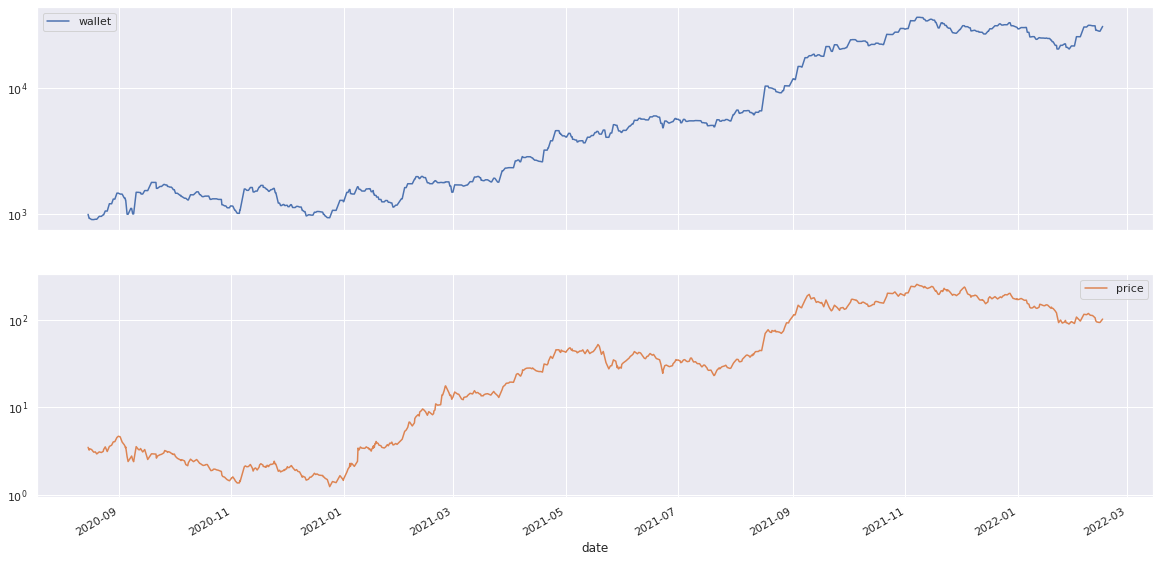

In [7]:
BTobject.plot_wallet_vs_price(dfTrades=dfTrades)